In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!git clone https://gitlab.com/d371/time-series.git

fatal: destination path 'time-series' already exists and is not an empty directory.


In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from google.colab import data_table
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import string
import nltk
import sys

In [31]:
class Config:
  def __init__(self):
    print("Load Config")
    
    # Init Directory
    self.dir = "/content/time-series/climate.csv"
    self.model_dir = "/content/drive/MyDrive/Dicoding/"
    
    # Training Param
    self.verbose = 1
    self.batch_size = 1000
    self.epochs = 10
    self.optimizer = RMSprop(learning_rate=2e-5, momentum=0.95)
    self.metrics = 'mae'

    # Dataset Param
    self.win_size = 144
    self.shuffle = 9999

class DicodingTS(Config):
  def __init__(self):
    super().__init__()
    print("Starting Time Series Program")
  
  def build_dataset(self, data):
    self.datas = data
    self.datas = tf.expand_dims(self.datas, axis=1)
    self.datas = tf.data.Dataset.from_tensor_slices(self.datas)
    self.datas = self.datas.window(self.win_size + 1, shift=1, drop_remainder=True)
    self.datas = self.datas.flat_map(lambda w: w.batch(self.win_size + 1))
    self.datas = self.datas.shuffle(self.shuffle)
    self.datas = self.datas.map(lambda w: (w[:-1], w[-1:]))
    return self.datas.repeat(self.epochs).batch(self.batch_size).prefetch(1)
  
  def build_model(self):
    self.checkpoint = ModelCheckpoint(filepath=self.model_dir+"TSmodel.h5", 
                                      monitor="val_mae",
                                      verbose=self.verbose, 
                                      save_best_only=True,
                                      mode="min")

    self.train_dset = self.mbar[:np.int(0.8*len(self.data_train))]
    self.validation_dset = self.mbar[np.int(0.8*len(self.data_train)):]

    self.train_set = self.build_dataset(self.train_dset)
    self.validation_set = self.build_dataset(self.validation_dset)
    
    if os.path.exists(self.model_dir+"TSmodel.h5"):
      print("Load Model From ", self.model_dir+"TSmodel.h5")
      self.model = tf.keras.models.load_model(self.model_dir+"TSmodel.h5")
    else:
      print("First Time Training")
      self.model = tf.keras.models.Sequential([Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                                              Bidirectional(tf.keras.layers.LSTM(64)),
                                              tf.keras.layers.Dense(128, activation="relu"),
                                              tf.keras.layers.Dense(16, activation="relu"),
                                              tf.keras.layers.Dense(1),
                                              ])
    
  def train(self):
    self.model.compile(loss=tf.keras.losses.Huber(),
                       optimizer=self.optimizer,
                       metrics=[self.metrics])
    self.history = self.model.fit(self.train_set,
                                  epochs=self.epochs,
                                  steps_per_epoch=len(self.train_dset)//1000,
                                  validation_data = self.validation_set, 
                                  validation_steps = len(self.validation_dset)//1000,
                                  callbacks = [self.checkpoint]
                                  )
  
  def plot(self, hist):
    plt.plot(hist['Loss'])
    plt.plot(hist['Val Loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss'], loc='upper right')
    plt.show()

    plt.plot(hist['Acc'])
    plt.plot(hist['Val Acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='lower right')
    plt.show()
  
  def start(self):
    self.load_data()
    self.build_model()
    self.train()
  
  def load_data(self):
    self.data = pd.read_csv(self.dir)
    self.data_date = self.data["Date Time"]
    self.data_mbar = self.data["VPdef (mbar)"]
    self.data_train = pd.concat([self.data_date, self.data_mbar], axis = 1)

    self.date = self.data_train["Date Time"].values
    self.mbar = self.data_train["VPdef (mbar)"].values
    return self.data_train

In [32]:
TS = DicodingTS()
TS.start()

Load Config
Starting Time Series Program
First Time Training
Epoch 1/10
336/336 [==============================] - 95s 262ms/step - loss: 0.3991 - mae: 0.6087 - val_loss: 0.0612 - val_mae: 0.2036

Epoch 00001: val_mae improved from inf to 0.20356, saving model to /content/drive/MyDrive/Dicoding/TSmodel.h5
Epoch 2/10
336/336 [==============================] - 90s 269ms/step - loss: 0.0376 - mae: 0.1567 - val_loss: 0.0445 - val_mae: 0.1651

Epoch 00002: val_mae improved from 0.20356 to 0.16509, saving model to /content/drive/MyDrive/Dicoding/TSmodel.h5
Epoch 3/10
336/336 [==============================] - 91s 272ms/step - loss: 0.0320 - mae: 0.1434 - val_loss: 0.0401 - val_mae: 0.1556

Epoch 00003: val_mae improved from 0.16509 to 0.15558, saving model to /content/drive/MyDrive/Dicoding/TSmodel.h5
Epoch 4/10
336/336 [==============================] - 91s 272ms/step - loss: 0.0303 - mae: 0.1379 - val_loss: 0.0376 - val_mae: 0.1517

Epoch 00004: val_mae improved from 0.15558 to 0.15174, sa

In [33]:
history = pd.DataFrame({"Acc" : TS.history.history['mae'],
                        "Loss" : TS.history.history['loss'],
                        "Val Acc" : TS.history.history['val_mae'],
                        "Val Loss" : TS.history.history['val_loss'],
                        })
if os.path.exists(TS.model_dir+"TShistory.csv"):
  print("Append Existing History")
  history.to_csv(TS.model_dir+'TShistory.csv', mode='a', index=False, header=False)
else:
  print("Write New History")
  history.to_csv(TS.model_dir+'TShistory.csv', mode='w', index=False, header=True)

Write New History


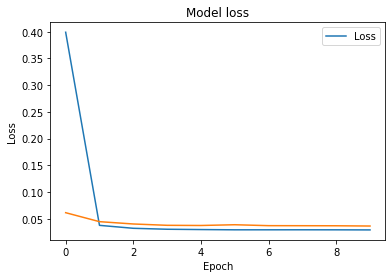

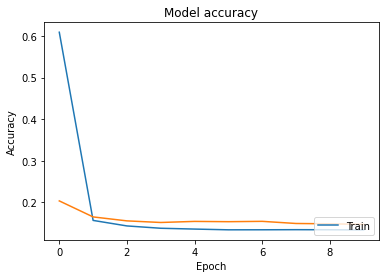

In [34]:
plt_history = pd.read_csv(TS.model_dir+'TShistory.csv')
TS.plot(plt_history)

In [35]:
data_table.DataTable(TS.data_train, include_index=False, num_rows_per_page=10)

,Date Time,VPdef (mbar)
0,01.01.2009 00:10:00,0.22
1,01.01.2009 00:20:00,0.21
2,01.01.2009 00:30:00,0.20
3,01.01.2009 00:40:00,0.19
4,01.01.2009 00:50:00,0.19
...,...,...
420546,31.12.2016 23:20:00,1.22
420547,31.12.2016 23:30:00,1.44
420548,31.12.2016 23:40:00,1.55
420549,31.12.2016 23:50:00,1.26
